#  Load libraries 

In [1]:
# Python libraries
# Classic,data manipulation and linear algebra
import pandas as pd
import numpy as np

#plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

# Data processing, metrics and modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics



# Read the data

In [2]:
col_names = ['pregnant','glucose','bp','skin','insulin','bmi','pedigree','age','diabetes']
data=pd.read_csv("/Users/ranjitsah/Documents/Bachelorarbeit/Data Analysis/diabetes.csv",header=0,names=col_names)

In [3]:
data.shape

(768, 9)

In [4]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
pregnant    768 non-null int64
glucose     768 non-null int64
bp          768 non-null int64
skin        768 non-null int64
insulin     768 non-null int64
bmi         768 non-null float64
pedigree    768 non-null float64
age         768 non-null int64
diabetes    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

pregnant  glucose  bp  skin  insulin   bmi  pedigree  age  diabetes
0         6      148  72    35        0  33.6     0.627   50         1
1         1       85  66    29        0  26.6     0.351   31         0
2         8      183  64     0        0  23.3     0.672   32         1
3         1       89  66    23       94  28.1     0.167   21         0
4         0      137  40    35      168  43.1     2.288   33         1

In [5]:
data.nunique()

pregnant     17
glucose     136
bp           47
skin         51
insulin     186
bmi         248
pedigree    517
age          52
diabetes      2
dtype: int64

In [6]:
data.describe().T

count        mean         std     min       25%       50%  \
pregnant  768.0    3.845052    3.369578   0.000   1.00000    3.0000   
glucose   768.0  120.894531   31.972618   0.000  99.00000  117.0000   
bp        768.0   69.105469   19.355807   0.000  62.00000   72.0000   
skin      768.0   20.536458   15.952218   0.000   0.00000   23.0000   
insulin   768.0   79.799479  115.244002   0.000   0.00000   30.5000   
bmi       768.0   31.992578    7.884160   0.000  27.30000   32.0000   
pedigree  768.0    0.471876    0.331329   0.078   0.24375    0.3725   
age       768.0   33.240885   11.760232  21.000  24.00000   29.0000   
diabetes  768.0    0.348958    0.476951   0.000   0.00000    0.0000   

                75%     max  
pregnant    6.00000   17.00  
glucose   140.25000  199.00  
bp         80.00000  122.00  
skin       32.00000   99.00  
insulin   127.25000  846.00  
bmi        36.60000   67.10  
pedigree    0.62625    2.42  
age        41.00000   81.00  
diabetes    1.00000    1.00

In [7]:
data['insulin'].max()

846

# Target variable

In [8]:


# 2 datasets
#D for diabities person
# H for healthy person
D = data[(data['diabetes'] != 0)]
H = data[(data['diabetes'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['diabetes'].value_counts().values.tolist(), 
                    y = ['healthy','diabetes' ], 
                    orientation = 'h', 
                    text=data['diabetes'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetes'], values = data['diabetes'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [9]:
target_count()
target_percent()

# Data Preparation(Missing values)

In [10]:
zeroCols = ['glucose', 'bp', 'skin', 'insulin','bmi'] # Columns with incorrect Zero values 
df2 = data.copy() # create a copy of the original dataframe 
df2[zeroCols] = df2[zeroCols].replace(0,np.NaN) #Replace 0s with NaNs
df2.head()


pregnant  glucose    bp  skin  insulin   bmi  pedigree  age  diabetes
0         6    148.0  72.0  35.0      NaN  33.6     0.627   50         1
1         1     85.0  66.0  29.0      NaN  26.6     0.351   31         0
2         8    183.0  64.0   NaN      NaN  23.3     0.672   32         1
3         1     89.0  66.0  23.0     94.0  28.1     0.167   21         0
4         0    137.0  40.0  35.0    168.0  43.1     2.288   33         1

In [11]:
df2.isnull().sum()/len(df2)*100

pregnant     0.000000
glucose      0.651042
bp           4.557292
skin        29.557292
insulin     48.697917
bmi          1.432292
pedigree     0.000000
age          0.000000
diabetes     0.000000
dtype: float64

In [12]:
dataset=df2.copy()

In [13]:
# Define missing plot to detect all missing values in dataset
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(dataset.isnull().sum(), columns = ['Count'])

    trace = go.Bar(x = null_feat.index, y = null_feat  ['Count'] ,opacity = 0.8, text = null_feat ['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))


    fig = dict(data = [trace])
    py.iplot(fig)
    

In [14]:
missing_plot(dataset, 'diabities')

# Replacing  Missing Values and EDA

In [15]:
# function To Fill Missing values
def median_target(var):   
    temp = df2[df2[var].notnull()]
    temp = temp[[var, 'diabetes']].groupby(['diabetes'])[[var]].median().reset_index()
    return temp

# Insulin

In [16]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', 'green']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [17]:
plot_distribution('insulin',0)

In [18]:
median_target('insulin')



diabetes  insulin
0         0    102.5
1         1    169.5

In [19]:
df2.loc[(df2['diabetes'] == 0 ) & (df2['insulin'].isnull()), 'insulin'] = 102.5 #+ np.random.normal(0,1,236)
df2.loc[(df2['diabetes'] == 1 ) & (df2['insulin'].isnull()), 'insulin'] = 169.5 #+ np.random.normal(0,1,138)
#(236,138)

# Glucose

In [20]:
plot_distribution('glucose',0)

In [21]:
median_target('glucose')

diabetes  glucose
0         0    107.0
1         1    140.0

In [22]:
df2.loc[(df2['diabetes'] == 0 ) & (df2['glucose'].isnull()), 'glucose'] = 107.0
df2.loc[(df2['diabetes'] == 1 ) & (df2['glucose'].isnull()), 'glucose'] = 140.0

# Skin

In [23]:
plot_distribution('skin',0)

In [24]:
median_target('skin')

diabetes  skin
0         0  27.0
1         1  32.0

In [25]:
df2.loc[(df2['diabetes'] == 0 ) & (df2['skin'].isnull()), 'skin'] = 27.0 #+ np.random.normal(0,1,139)
df2.loc[(df2['diabetes'] == 1 ) & (df2['skin'].isnull()), 'skin'] = 32.0 #+ np.random.normal(0,1,88)

#(139,88)

# BP

In [26]:
plot_distribution('bp',0)

In [27]:
median_target('bp')

diabetes    bp
0         0  70.0
1         1  74.5

In [28]:
df2.loc[(df2['diabetes'] == 0 ) & (df2['bp'].isnull()), 'bp'] = 70.0 #+ np.random.normal(0,1,19)
df2.loc[(df2['diabetes'] == 1 ) & (df2['bp'].isnull()), 'bp'] = 74.0 #+ np.random.normal(0,1,16)
#(19,16)

# BMI

In [29]:
plot_distribution('bmi',0)

In [30]:
median_target('bmi')

diabetes   bmi
0         0  30.1
1         1  34.3

In [31]:
df2.loc[(data['diabetes'] == 0 ) & (df2['bmi'].isnull()), 'bmi'] = 30.1
df2.loc[(data['diabetes'] == 1 ) & (df2['bmi'].isnull()), 'bmi'] = 34.3

# Age,pregnant and pedigree

In [32]:
plot_distribution('age', 0)
plot_distribution('pregnant', 0)
plot_distribution('pedigree', 0)

# Boxplot

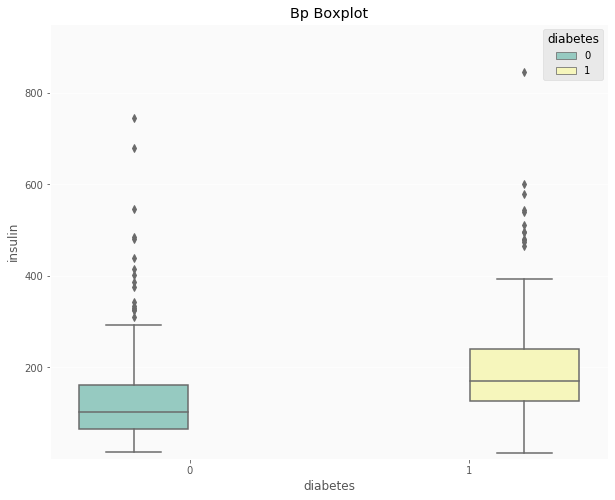

In [33]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(10, 8))

ax.set_facecolor('#fafafa')
ax.set(ylim=(.5, 950))
plt.ylabel('Bp')
plt.title("Bp Boxplot")
ax = sns.boxplot(x='diabetes',y='insulin',hue='diabetes',data=dataset,
 palette="Set3")



In [34]:
def correlation_plot():
    #correlation
    correlation = df2.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [35]:
correlation_plot()

# creating Decision Tree Model

In [36]:
array=df2.values
feature_cols=['pregnant','glucose','bp','skin','insulin','bmi','pedigree','age']

In [37]:
#split dataset in features and target variable
X=array[:,0:8]
y=array[:,8]

In [38]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [39]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state=1)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)



In [40]:
from sklearn.metrics import accuracy_score

# Model Accuracy, how often is the classifier correct?
print(round(accuracy_score(y_test,y_pred)*100,2))

84.42


In [41]:
from sklearn.metrics  import confusion_matrix,classification_report
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[125  21]
 [ 15  70]]


In [42]:
from sklearn.metrics  import confusion_matrix,classification_report
confusion_matrix = classification_report(y_test,y_pred) #output_dict=True
print(confusion_matrix)

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       146
         1.0       0.77      0.82      0.80        85

   micro avg       0.84      0.84      0.84       231
   macro avg       0.83      0.84      0.83       231
weighted avg       0.85      0.84      0.85       231



In [43]:
print(confusion_matrix)

              precision    recall  f1-score   support

         0.0       0.89      0.86      0.87       146
         1.0       0.77      0.82      0.80        85

   micro avg       0.84      0.84      0.84       231
   macro avg       0.83      0.84      0.83       231
weighted avg       0.85      0.84      0.85       231



In [44]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

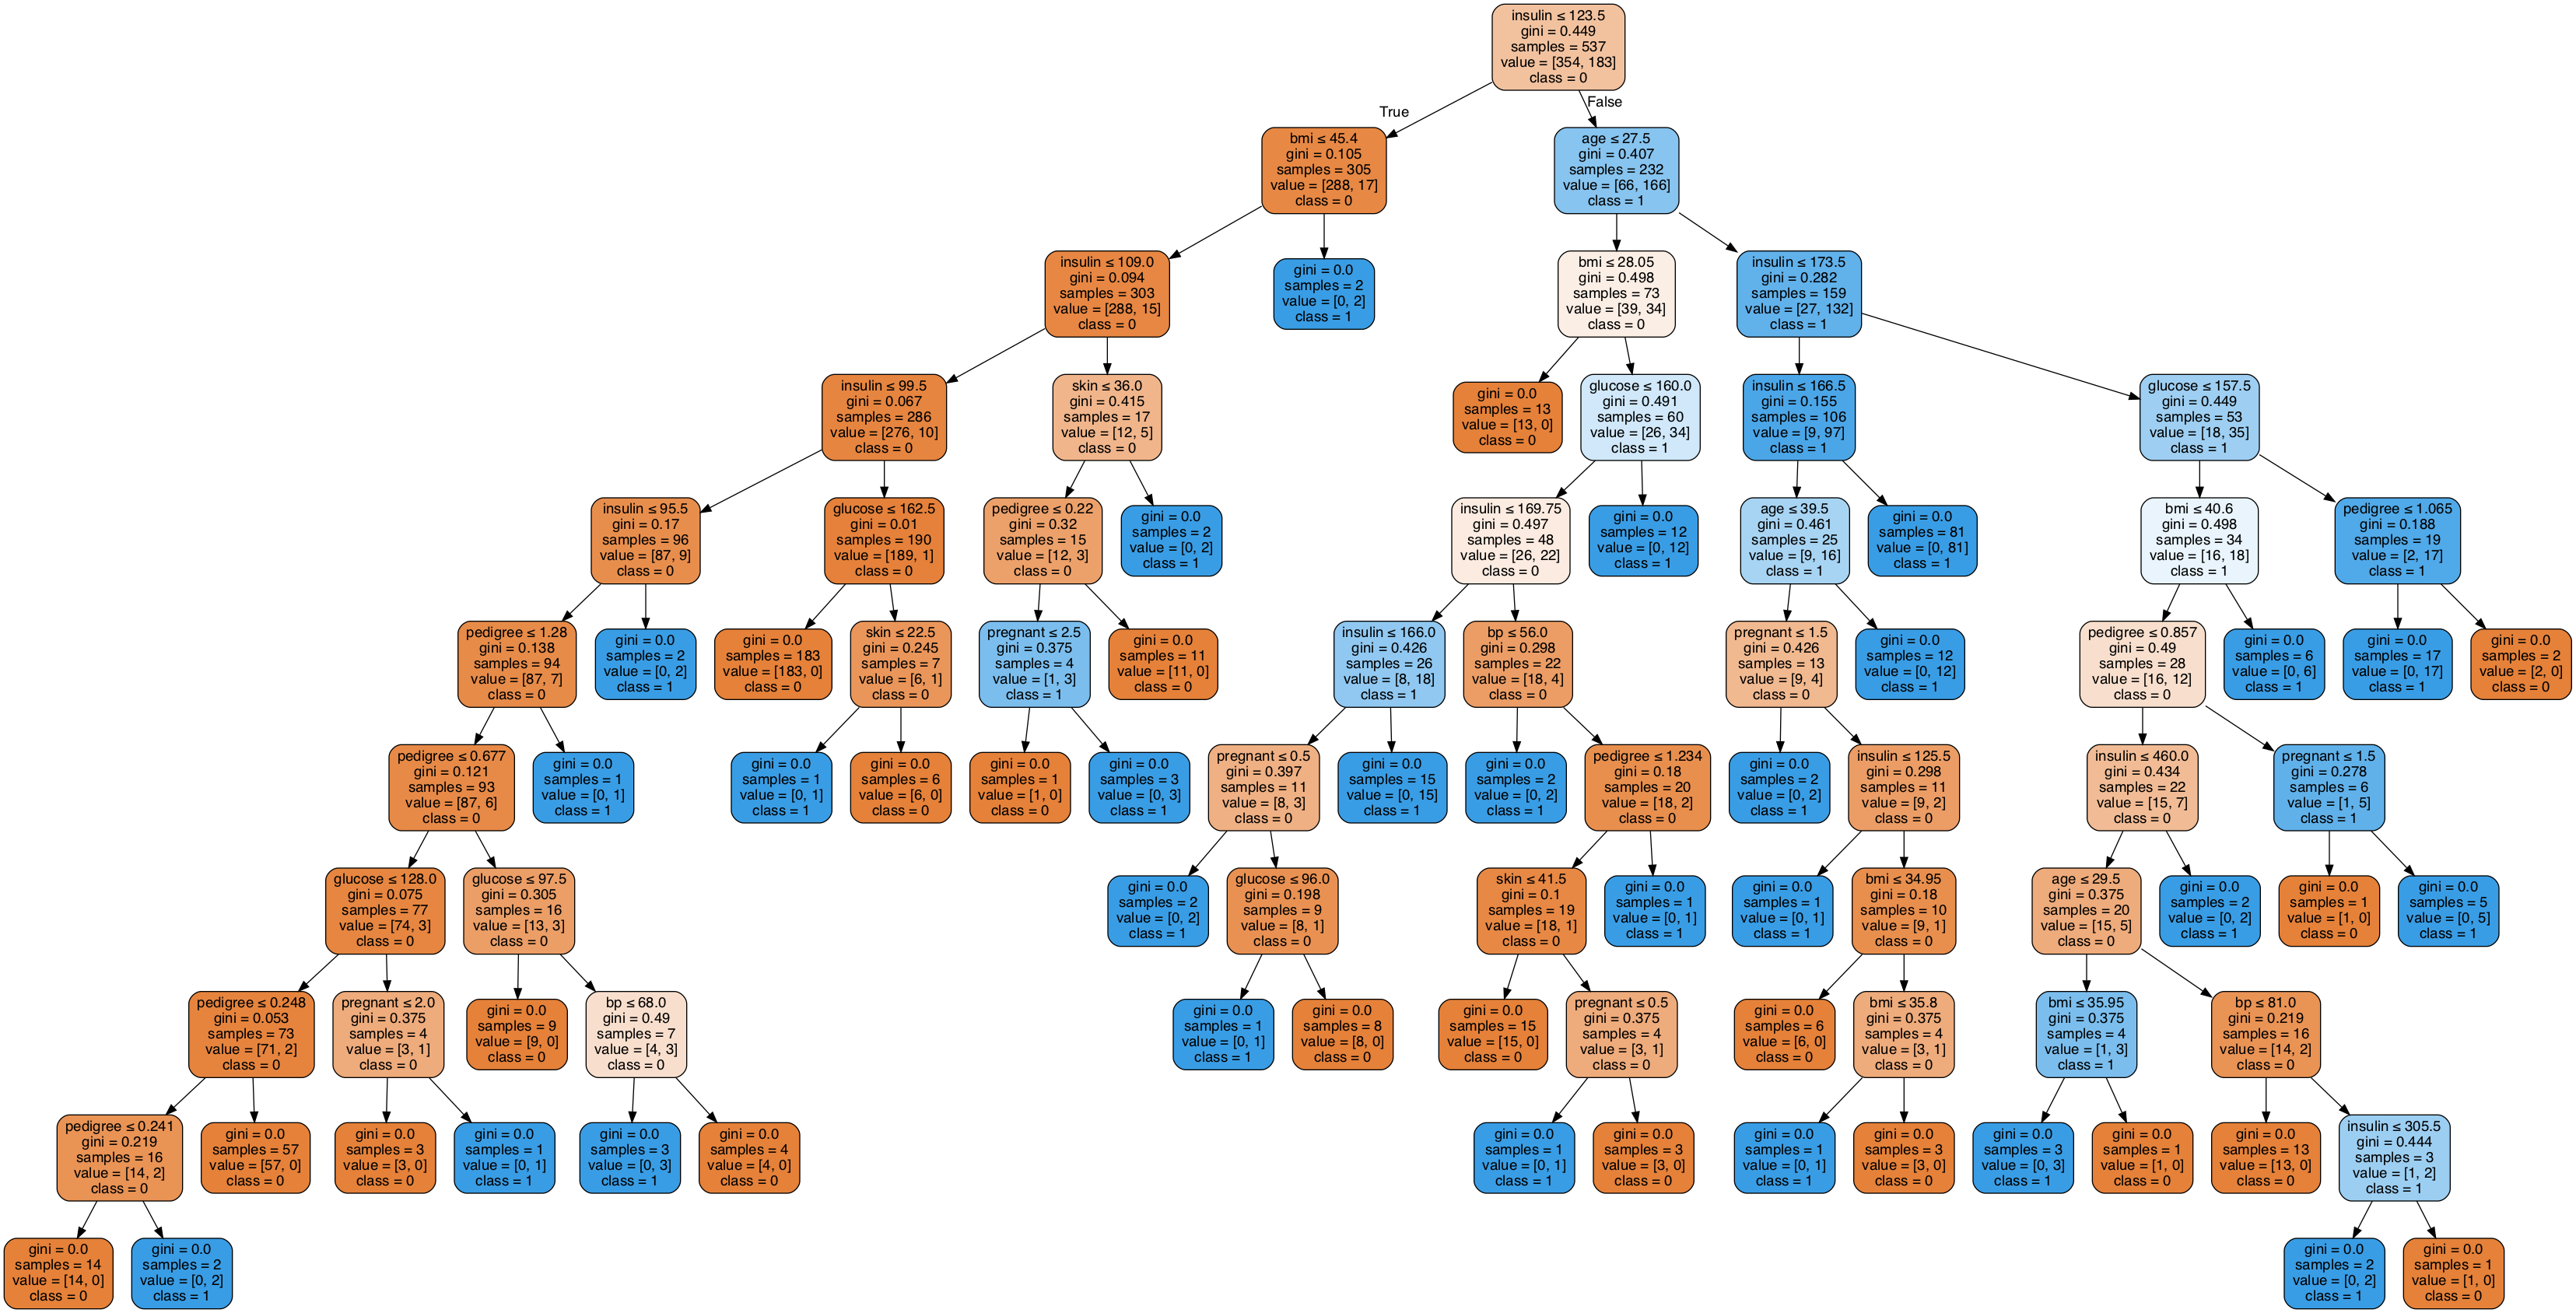

In [46]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

# optimizing Decision Tree performance

In [47]:

clf = DecisionTreeClassifier(criterion='entropy',max_depth=2)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)


In [48]:
# Model Accuracy, how often is the classifier correct?
print(round(metrics.accuracy_score(y_test,y_pred)*100,2))

85.28


In [49]:
from sklearn.metrics  import confusion_matrix,classification_report
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[136  10]
 [ 24  61]]


In [50]:
from sklearn.metrics  import confusion_matrix,classification_report
confusion_matrix = classification_report(y_test,y_pred) #output_dict=True

In [51]:
print(confusion_matrix)

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       146
         1.0       0.86      0.72      0.78        85

   micro avg       0.85      0.85      0.85       231
   macro avg       0.85      0.82      0.84       231
weighted avg       0.85      0.85      0.85       231



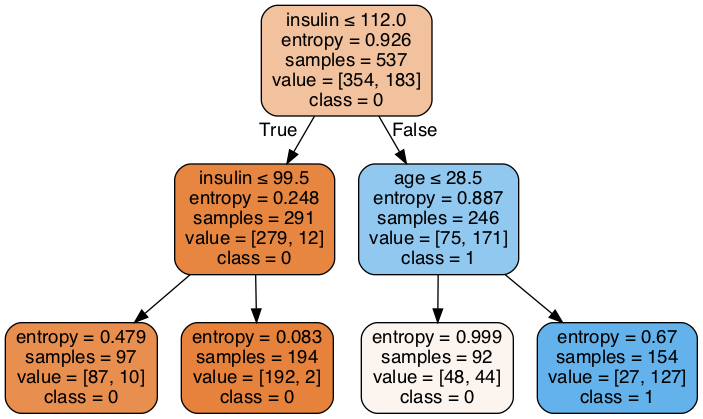

In [52]:
from sklearn.externals.six import StringIO  
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes_final.png')
Image(graph.create_png())

# Roc- AUC Analysis for Decision Tree 

In [53]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)




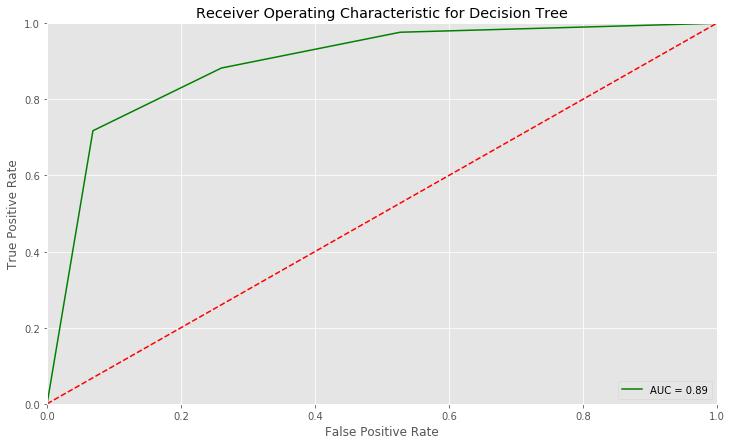

In [54]:

plt.figure(figsize=(12,7))
plt.title('Receiver Operating Characteristic for Decision Tree')
plt.plot(fpr, tpr, 'green', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('/Users/ranjitsah/Downloads/roc_auc_dctree.png')


#   Comparing with Randomforest model

In [55]:
rclf = RandomForestClassifier(random_state=5)

In [56]:
rclf = rclf.fit(X_train,y_train)
y_pred = rclf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print(round(metrics.accuracy_score(y_test,y_pred)*100,2))

90.48


In [57]:
from sklearn.metrics  import confusion_matrix,classification_report
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[135  11]
 [ 11  74]]


In [58]:
confusion_matrix=classification_report(y_test,y_pred)


In [59]:
print(confusion_matrix)

              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       146
         1.0       0.87      0.87      0.87        85

   micro avg       0.90      0.90      0.90       231
   macro avg       0.90      0.90      0.90       231
weighted avg       0.90      0.90      0.90       231



# Roc- AUC Analysis for Random forest


In [60]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = rclf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)



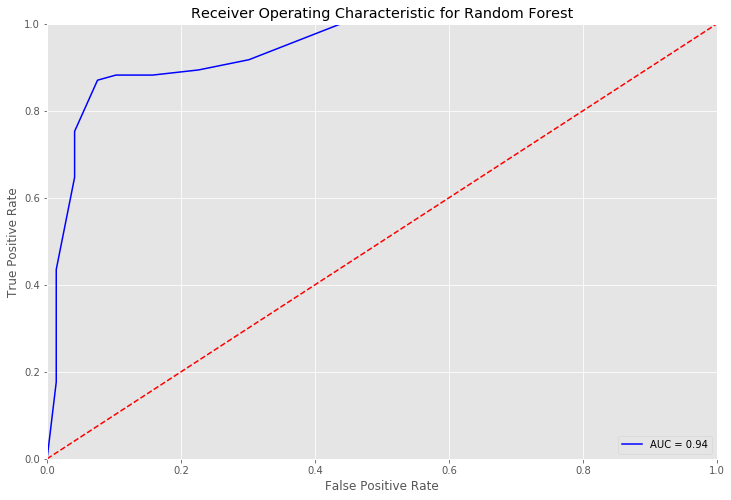

In [61]:
# method I: plt
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic for Random Forest')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('/Users/ranjitsah/Downloads/roc_rf.png')

# comparing with LogisticRegression

In [62]:
## Importing stats models for running logistic regression
import statsmodels.api as sm
from statsmodels.formula.api import logit

In [63]:
## Defining the model and assigning Y (Dependent) and Age (Independent Variables)
model_lin = sm.GLM.from_formula("diabetes ~ age",family=sm.families.Binomial(), data=df2)
## Fitting the model and publishing the results
result_lin = model_lin.fit()
print(result_lin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               diabetes   No. Observations:                  768
Model:                            GLM   Df Residuals:                      766
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -475.36
Date:                Tue, 16 Jun 2020   Deviance:                       950.72
Time:                        15:25:36   Pearson chi2:                     761.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.0475      0.239     -8.572      0.0

In [64]:

## Defining the model and assigning Y (Dependent) and X (Independent Variables)
model_lin = sm.GLM.from_formula("diabetes ~ pregnant+glucose+skin+bp+insulin+bmi+pedigree+age",family=sm.families.Binomial(), data=df2)
## Fitting the model and publishing the results
result_lin = model_lin.fit()
print(result_lin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               diabetes   No. Observations:                  768
Model:                            GLM   Df Residuals:                      759
Model Family:                Binomial   Df Model:                            8
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -344.33
Date:                Tue, 16 Jun 2020   Deviance:                       688.67
Time:                        15:25:37   Pearson chi2:                 1.59e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2850      0.832    -11.162      0.0

# Inference from the Logistic Regression¶

-To identify which variables influence the diabetes, we will look at the p-value of each variable. We expect the p-value to be less than 0.05(alpha risk)

-When p-value<0.05, we can say the variable influences the outcome
Hence we will eliminate  Age and bp, then we will re run the model.


In [65]:

## Defining the model and assigning Y (Dependent) and Age (Independent Variables)
model_lin = sm.GLM.from_formula("diabetes ~ pregnant+glucose+skin+insulin+bmi+pedigree",family=sm.families.Binomial(), data=df2)
## Fitting the model and publishing the results
result_lin = model_lin.fit()
print(result_lin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               diabetes   No. Observations:                  768
Model:                            GLM   Df Residuals:                      761
Model Family:                Binomial   Df Model:                            6
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -345.26
Date:                Tue, 16 Jun 2020   Deviance:                       690.52
Time:                        15:25:38   Pearson chi2:                 1.65e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -9.2211      0.724    -12.742      0.0

# Logit Model with significant variables

In [66]:
cols=["pregnant", "glucose","skin","insulin","bmi","pedigree"]
X=df2[cols]
y=df2.diabetes

In [67]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test


In [68]:
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression()
logreg=logreg.fit(X_train,y_train)

In [69]:
y_pred=logreg.predict(X_test)

In [70]:

# Model Accuracy, how often is the classifier correct?
print(round(accuracy_score(y_test,y_pred)*100,2))

81.39


In [71]:
from sklearn.metrics  import confusion_matrix,classification_report
confusion_matrix = confusion_matrix(y_test,y_pred)
print(confusion_matrix)

[[136  10]
 [ 33  52]]


In [72]:
confusion_matrix=classification_report(y_test,y_pred)

In [73]:
print(confusion_matrix)

              precision    recall  f1-score   support

           0       0.80      0.93      0.86       146
           1       0.84      0.61      0.71        85

   micro avg       0.81      0.81      0.81       231
   macro avg       0.82      0.77      0.79       231
weighted avg       0.82      0.81      0.81       231



# ROC-AUC Analysis for Logistics Regression

In [74]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = logreg.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)



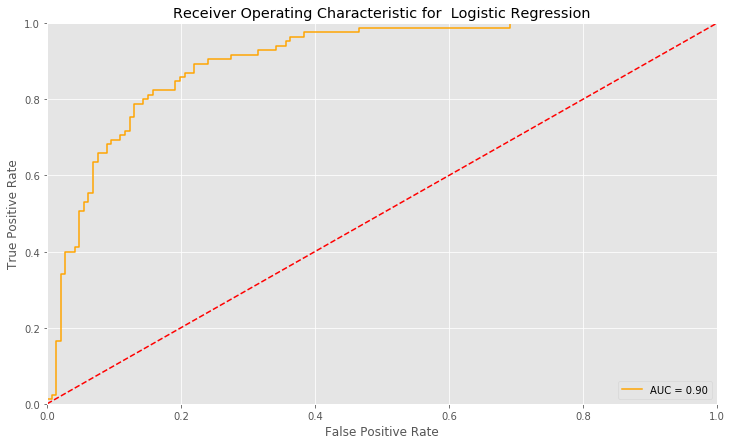

In [75]:

plt.figure(figsize=(12,7))
plt.title('Receiver Operating Characteristic for  Logistic Regression')
plt.plot(fpr, tpr, 'orange', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('/Users/ranjitsah/Downloads/roc_lgr.png')

# Comparison between the Models

In [76]:
array=df2.values
#split dataset in features and target variable
X=array[:,0:8]
y=array[:,8]

In [77]:


# prepare models
from sklearn import model_selection
models = []
models.append(('LogisticRegression',LogisticRegression()))
models.append(('DecisionTree', DecisionTreeClassifier()))
models.append((' RandomForest', RandomForestClassifier()))



In [78]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=7)
	cv_results = model_selection.cross_val_score(model, X,y, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LogisticRegression: 0.778640 (0.041128)
DecisionTree: 0.842498 (0.033907)
 RandomForest: 0.862064 (0.038377)


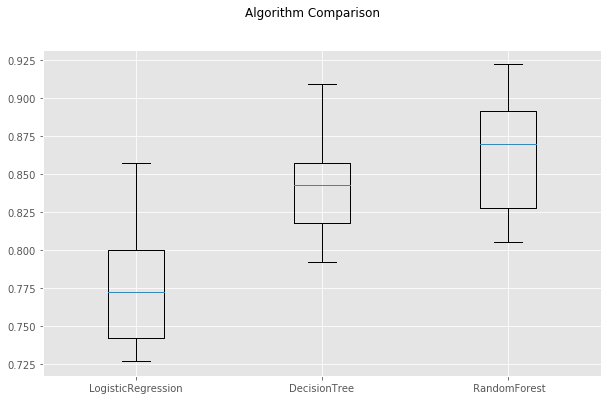

In [79]:

# boxplot algorithm comparison
fig = plt.figure(figsize=(10,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()